In [2]:
import cmocean as cmo
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import matplotlib as mpl
import numpy as np
import xarray as xr
import MITgcmutils as MIT
import seaborn as sns
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter

In [3]:
sns.set_context('notebook')
outdir = '/Volumes/Esteban_SSD/Maestría/MITgcm/verification/BayIW/run_expand/mnc_0001/'
outdir2 = '/Volumes/Esteban_SSD/Maestría/MITgcm/verification/BayIW/run_expand_nobay/mnc_0001/'

In [4]:
#Archivos con bahía
nc = MIT.mnc_files(outdir+'state.0000000000.t*.nc')
gr = MIT.mnc_files(outdir+'grid.t*.nc')
#Archivos SIN BAHÍA
nc2 = MIT.mnc_files(outdir2+'state.0000000000.t*.nc')
#gr2 = MIT.mnc_files(outdir2+'grid.t*.nc')

In [5]:
# Load some grid variables
depth = gr.variables['Depth'][:]
hFacC = gr.variables['HFacC'][:]
XC = gr.variables['XC'][:]
YC = gr.variables['YC'][:]
XG = gr.variables['XG'][:]
YG = gr.variables['YG'][:]
RC = gr.variables['RC'][:]
RL = gr.variables['RL'][:]
mask = np.ma.getmask(np.ma.masked_values(depth, 0))
mask3D = np.ma.getmask(np.ma.masked_values(hFacC[:,:], 0))
time = nc.variables['T'][:]
timetotal = nc.variables['T'][:]

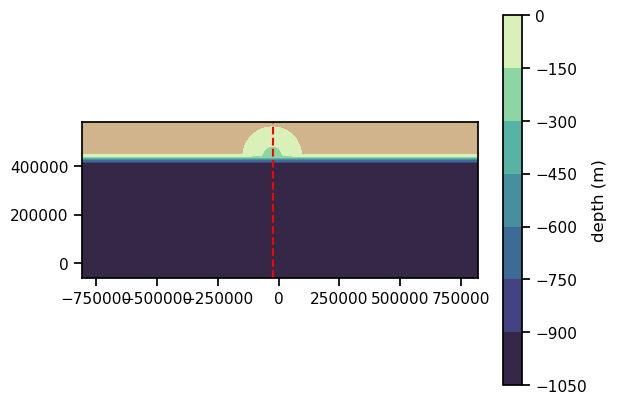

In [6]:
# Plot bathymetry
fig, ax = plt.subplots(1,1)
ax.set_facecolor('tan')
pc = ax.contourf(XC[0,:],YC[:,0],
                np.ma.masked_array(-depth, mask=mask),
                cmap=cmo.cm.deep_r)
cb = plt.colorbar(pc, label='depth (m)')
# Añade una línea en el eje Y para una coordenada específica en XC
x_coord = XC[0,136]# Cambia este valor a la coordenada de XC donde quieres la línea
ax.axvline(x=x_coord, color='red', linestyle='--', label=f'XC = {x_coord}')

ax.set_aspect(1)  

In [7]:
depth.shape

(320, 272)

In [8]:
#Comprobar la simetría de mi modelo
len(depth[0,:136]) - len(depth[0,136:])

0

In [9]:
#Resta de simetría
Symm_Depth= depth[:,:136]-np.flip(depth[:,136:], axis=1)
print(Symm_Depth.shape)

(320, 136)


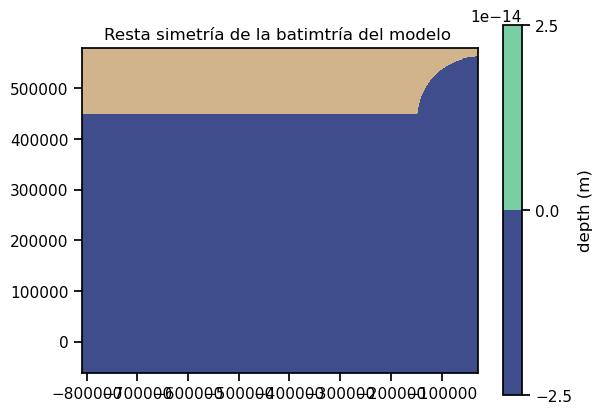

In [10]:
# Plot bathymetry
fig, ax = plt.subplots(1,1)
ax.set_facecolor('tan')
pc = ax.contourf(XC[0,:136],YC[:,0],
                np.ma.masked_array(-Symm_Depth, mask=mask[:,:136]),
                cmap=cmo.cm.deep_r)
cb = plt.colorbar(pc, label='depth (m)')
ax.set_title('Resta simetría de la batimtría del modelo ')
ax.set_aspect(1)  

# Checar el proceso en que la batimetría se hace asimétrica
[ x ] Construcción del modelo

In [12]:
# Parámetros
h1 = 164 
L = 119000 
Z_max = -1493 - 164 # Profundidad en Y = -62000
Y_fondo= -62000
Fondo_lineal= -440000
Costa_extra= 20000
L_expansion = 2 * L
DelX = 200
DelY = 200#m

# Calcular nx y ny como enteros
nx_center = int(4 * L / DelX)
ny = int((L + Costa_extra + np.abs(Y_fondo)+ np.abs(Fondo_lineal)) / DelY) #L+ Talud continental +Expansión dominio Y
idx_start_slope=int(440000/DelY)
print(ny)
print(nx_center)

x_min_center = -L_expansion # m
x_max_center =  L_expansion # m
x_min_expand = - 800E3 # m
x_max_expand =  800E3 # m
y_min = -int(np.abs(Y_fondo)+ 440000) # m
y_max = int(119000 + 800) # m
ny_expand= 30

# Crear dominios en las regiones exteriores (-800E3 a -2L y 2L a 800E3) con crecimiento cuadrático
# Aseguramos que el primer incremento sea 200 m usando un factor adecuado 'k'.
k = DelX 

# Crear el vector para la expansión en Y
i_values_y =  np.arange(ny_expand+1)
# Crear el vector para la expansión del lado derecho 
#i_values_x = np.arange(int(np.sqrt((x_max_expand - x_max_center) / k)) + 1)
i_values_x =  np.arange(56)

x_right = x_max_center + (k * i_values_x**2)
y_expand = y_min -(k*i_values_y**2)

# Crear el vector para la expansión del lado izquierdo al reflejar y ordenar
x_left = -np.flip(x_right)
# Ordenar
y_expand = np.flip(y_expand) 

# Quitar los valores que se superponen con el centro
x_left = x_left[:-1]
x_right = x_right[1:]
y_expand = y_expand[:-1]
dx_expand = x_right[1:]-x_right[:-1]
dy_expand = y_expand[1:]-y_expand[:-1]

# Crear el dominio con un aumento lineal del delta x hacia los lados
x_center = np.linspace(-L_expansion, L_expansion, nx_center)  # Parte central de la bahía, con espaciado uniforme

# Crear el dominio Y (como antes, con espaciado uniforme)
y_center = np.linspace(Y_fondo + Fondo_lineal, L+Costa_extra, ny)

# Combinar las regiones para formar el dominio completo en Y
y_domain = np.concatenate((y_expand, y_center))

# Combinar todas las regiones para formar el dominio completo en X
x_domain = np.concatenate((x_left, x_center, x_right))

3205
2380


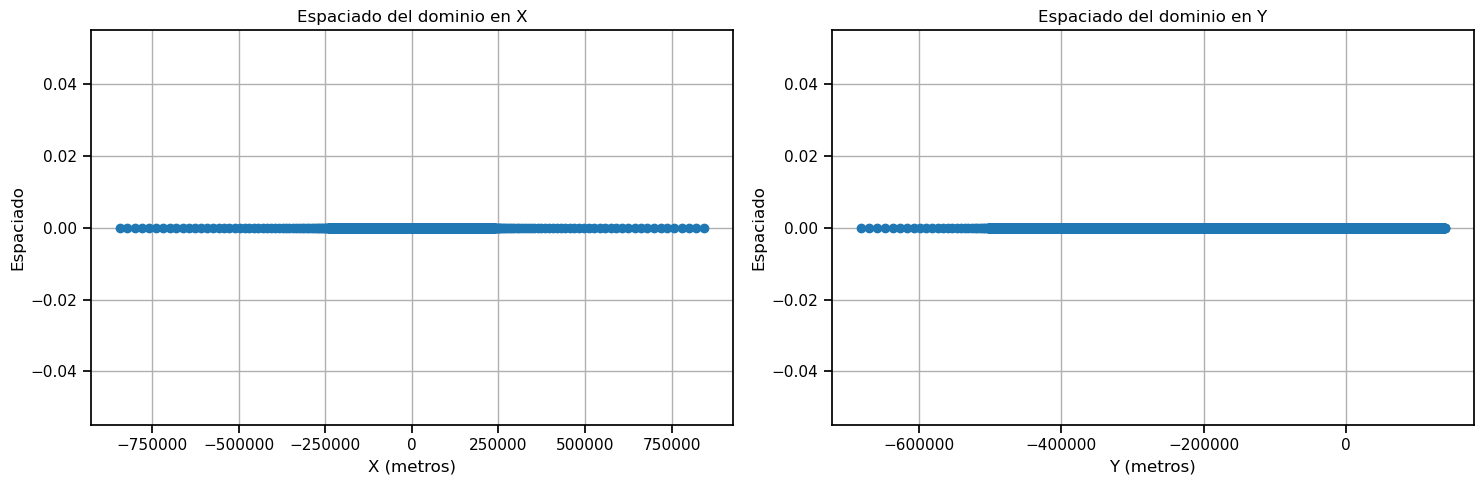

In [13]:
# Crear los subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Subplot 1: Espaciado en el eje X
ax1.plot(x_domain, np.zeros_like(x_domain), 'o-')
ax1.set_title("Espaciado del dominio en X")
ax1.set_xlabel("X (metros)")
ax1.set_ylabel("Espaciado")
ax1.grid(True)

# Subplot 2: Espaciado en el eje Y
ax2.plot(y_domain, np.zeros_like(y_domain), 'o-')
ax2.set_title("Espaciado del dominio en Y")
ax2.set_xlabel("Y (metros)")
ax2.set_ylabel("Espaciado")
ax2.grid(True)

# Mostrar el gráfico
plt.tight_layout()

In [14]:
# Crear el dominio Y (como antes, con espaciado uniforme)
X_domain, Y_domain = np.meshgrid(x_domain, y_domain)
Z_domain = np.zeros_like(X_domain)  # Inicializar Z con ceros

Idx_bahia_start=ny_expand+int(np.abs(Y_fondo + Fondo_lineal)/DelY)-1 #
Idx_slope_start= ny_expand+int(np.abs(Fondo_lineal)/DelY)-1 #y_domain[Idx_slope_start]=-62058.4942084942


Z_domain[:Idx_slope_start,:]=-1000

# --- Agregar pendiente en la región Z[:Y_idx_start_bahia-1, :] ---
# Interpolar pendiente entre Z[0,:] = Z_max y Z[Y_idx_start_bahia-1,:] = -h1
Y_slope = np.linspace(Z_max, -h1, Idx_bahia_start-Idx_slope_start)


# Asignar la pendiente a toda la región en el eje X
Z_domain[Idx_slope_start:Idx_bahia_start, :] = np.tile(Y_slope[:, None], (1, len(x_domain)))


# Aplicar un filtro gaussiano para suavizar las transiciones
Z_smooth = gaussian_filter(Z_domain, sigma=5)

# Cortar a 1000 m de profundidad
Z_domain_crop = np.where(Z_smooth>=-1000, Z_domain, -1000)

In [15]:
# Parámetros para la bahía
nr=int(L/DelY)
r = np.linspace(0, L, nr)  # Intervalo de r
theta = np.linspace(0, np.pi, 400)  # Intervalo angular para la revolución

# Definición de la función h(r) para la bahía
h_r = h1 * (1 - (r**2) / (L**2))

# Crear la malla de puntos para la bahía (en coordenadas polares)
R, Theta = np.meshgrid(r, theta)

# Convertir las coordenadas polares a cartesianas
X_bahia = R * np.cos(Theta)
Y_bahia = R * np.sin(Theta)

# Generar Z_bahia de acuerdo a la función h(r) en el dominio cartesiano
Z_bahia_polar = h1 * (1 - (R**2) / (L**2))

# Interpolamos los datos en el dominio cartesiano
# Crear una malla para interpolación más refinada
x_new = np.linspace(np.min(X_bahia), np.max(X_bahia), int(2*L/DelX)) #quiero que mida 2L
y_new = np.linspace(np.min(Y_bahia), np.max(Y_bahia),int(L/DelY))
X_new, Y_new = np.meshgrid(x_new, y_new)

# Puntos originales en coordenadas cartesianas
points = np.array([X_bahia.flatten(), Y_bahia.flatten()]).T
values = Z_bahia_polar.flatten()

# Interpolación en la nueva malla cartesiana
Z_bahia = -griddata(points, values, (X_new, Y_new), method='linear')
# Aplicar máscara para convertir NaN en 0
Z_bahia = np.nan_to_num(Z_bahia, nan=0)
print(Z_bahia.shape)

(595, 1190)


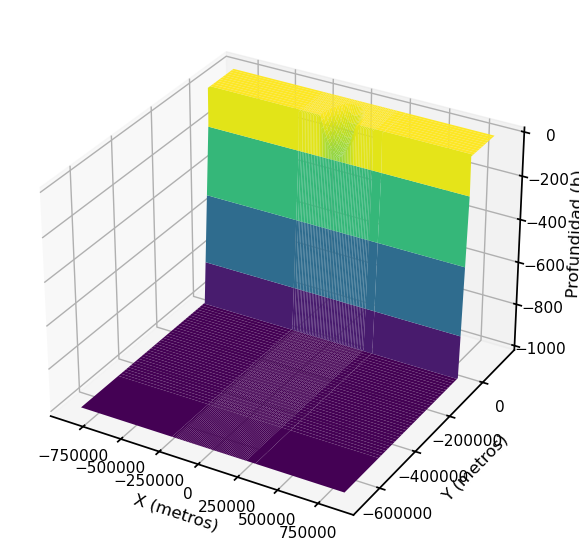

In [16]:
X_idx_start_bahia=int(L/DelX)+len(x_left)
X_idx_end = int(L/DelX) + len(x_new)+len(x_left)
#Y_idx_start_bahia= 311+890 #Y_domain[3100,0]=6.851585810589313
Y_idx_end_bahia= len(Z_bahia[:,0]) + Idx_bahia_start

Z_domain_crop[Idx_bahia_start:Y_idx_end_bahia,X_idx_start_bahia:X_idx_end]= Z_bahia[:,:]

# Graficar el sólido de revolución
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')


# Usar plot_surface para graficar la superficie
ax.plot_surface(X_domain, Y_domain, Z_domain_crop, cmap='viridis')
#ax.plot(X[] color='red', linewidth=2)

# Etiquetas de los ejes
ax.set_xlabel('X (metros)')
ax.set_ylabel('Y (metros)')
ax.set_zlabel('Profundidad (h)')

plt.show()

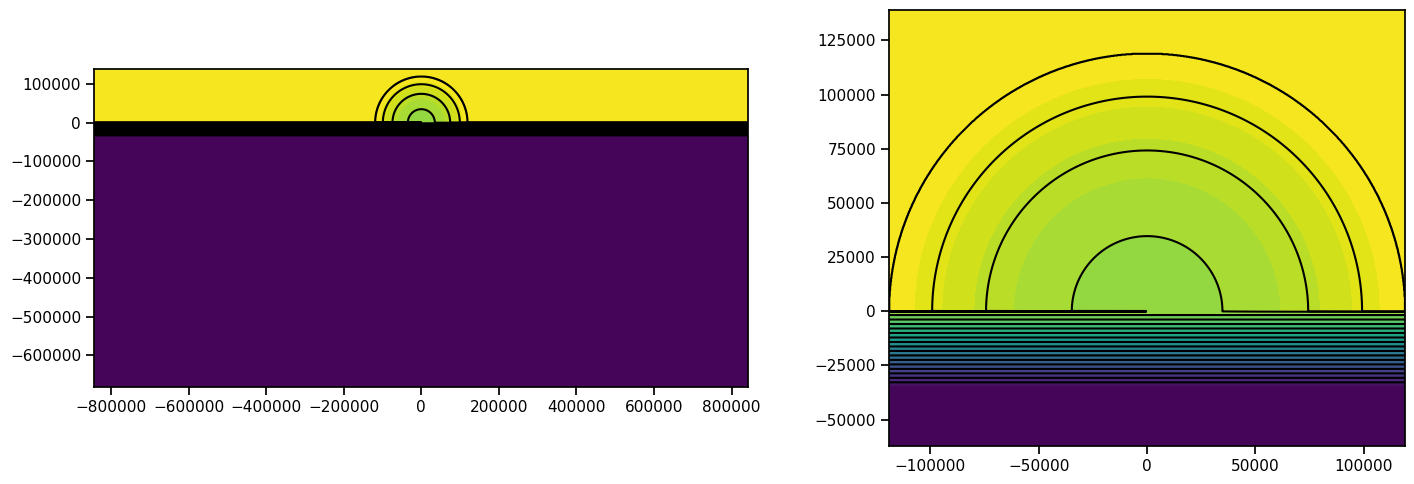

In [17]:
# Crear los subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Subplot 1: Espaciado en el eje X
ax1.contourf(X_domain, 
            Y_domain,
            Z_domain_crop,33, cmap='viridis')
ax1.contour(X_domain, 
            Y_domain,
            -Z_domain_crop,levels=np.arange(0,1600,50),colors='k')

ax1.set_aspect(1)

# Subplot 2: Espaciado en el eje Y
ax2.contourf(X_domain[Idx_slope_start:,X_idx_start_bahia:X_idx_end], 
            Y_domain[Idx_slope_start:,X_idx_start_bahia:X_idx_end],
            Z_domain_crop[Idx_slope_start:,X_idx_start_bahia:X_idx_end],33, cmap='viridis')
ax2.contour(X_domain[Idx_slope_start:,X_idx_start_bahia:X_idx_end], 
            Y_domain[Idx_slope_start:,X_idx_start_bahia:X_idx_end],
            -Z_domain_crop[Idx_slope_start:,X_idx_start_bahia:X_idx_end],levels=np.arange(0,1600,50),colors='k')

ax2.set_aspect(1)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [18]:
Idx_half=int(len(Z_domain_crop[1])/2)

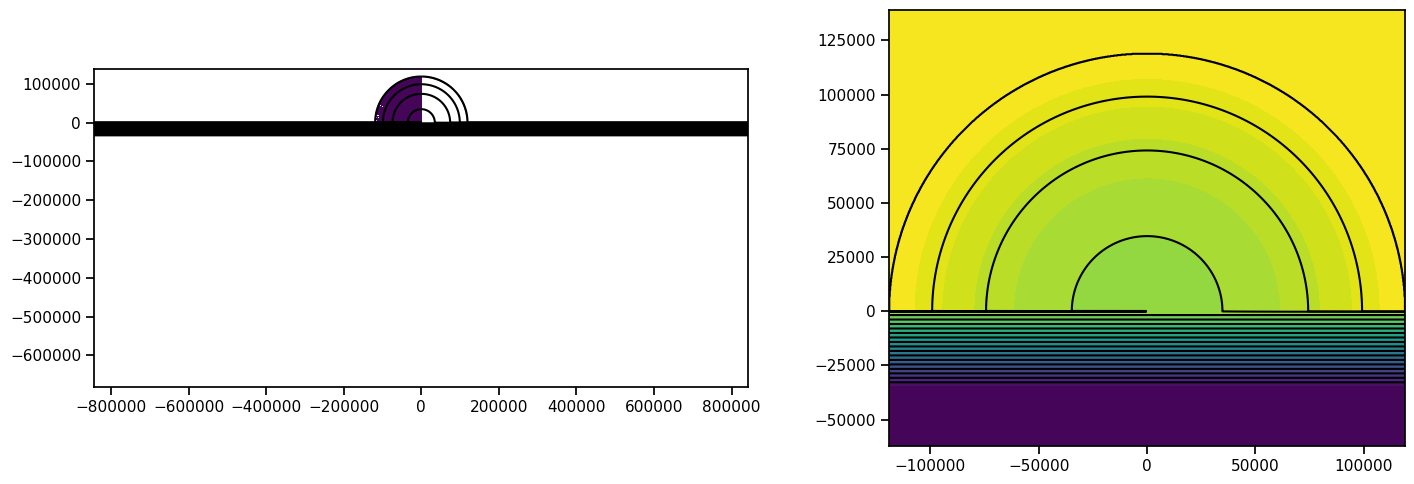

In [22]:
Z_Diff_Symm= Z_domain_crop[:,:Idx_half]-np.flip(Z_domain_crop[:,Idx_half:], axis=1)
# Crear los subplots

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Subplot 1: Espaciado en el eje X
ax1.contourf(X_domain[:,:Idx_half], 
            Y_domain[:,:Idx_half],
            Z_Diff_Symm,33, cmap='viridis')
ax1.contour(X_domain, 
            Y_domain,
            -Z_domain_crop,levels=np.arange(0,1600,50),colors='k')

ax1.set_aspect(1)

# Subplot 2: Espaciado en el eje Y
ax2.contourf(X_domain[Idx_slope_start:,X_idx_start_bahia:X_idx_end], 
            Y_domain[Idx_slope_start:,X_idx_start_bahia:X_idx_end],
            Z_domain_crop[Idx_slope_start:,X_idx_start_bahia:X_idx_end],33, cmap='viridis')
ax2.contour(X_domain[Idx_slope_start:,X_idx_start_bahia:X_idx_end], 
            Y_domain[Idx_slope_start:,X_idx_start_bahia:X_idx_end],
            -Z_domain_crop[Idx_slope_start:,X_idx_start_bahia:X_idx_end],levels=np.arange(0,1600,50),colors='k')

ax2.set_aspect(1)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [23]:
Y_domain.shape

(3235, 2490)

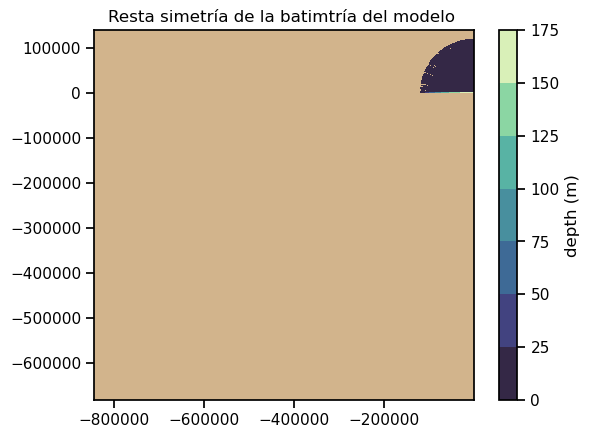

In [24]:
# Plot bathymetry

fig, ax = plt.subplots(1,1)
ax.set_facecolor('tan')
pc = ax.contourf(X_domain[:,:Idx_half],Y_domain[:,:Idx_half],
                 Z_Diff_Symm,
                cmap=cmo.cm.deep_r)
cb = plt.colorbar(pc, label='depth (m)')
ax.set_title('Resta simetría de la batimtría del modelo ')
ax.set_aspect(1)  